In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame


from numpy import dstack

import copy

import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import random

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from matplotlib import pyplot


## Load UCI data

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

UtrainX, Utrainy, UtestX, Utesty = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


## Load Data

In [3]:
def filter_active_keypoints(frame_df):
    #active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7] # trunk
    
    active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
    
    filtered_df  = frame_df[frame_df.index.isin(active_keypoints)]
    #filtered_df = frame_df

    return filtered_df

def get_frame_data(filepath):
    frame_data = pd.read_csv(filepath)
    
    x_data = filter_active_keypoints(frame_data.iloc[:, 0])
    y_data = filter_active_keypoints(frame_data.iloc[:, 1])
    
    #print(f"x_data shape: {x_data.shape}")
    #print(f"y_data shape: {y_data.shape}")
        
    h_stacked = np.hstack((x_data, y_data))
    #h_stacked = np.hstack((y_data))
    
    return h_stacked

def get_frame_file_path(frame_file_path_template, frame_idx):
    frame_file_path = frame_file_path_template.replace("[frame_idx]", str(frame_idx))
    return frame_file_path

def get_label(sample_dir_name):
    return 0 if sample_dir_name[0] == 'b' else 1

def get_y_labels(sample_dir_names):
    return [get_label(l) for l in sample_dir_names]

def get_frames_count(root_path, sample_dir_name):
    return len([Path(f).abspath() for f in glob(f"{root_path}/{sample_dir_name}" + '/*')])

def get_frames(root_path, sample_dir_name):
    frames = []
    for frame_idx in range(0, get_frames_count(root_path, sample_dir_name)):
        frame_file_path_template = f"{root_path}/{sample_dir_name}/{sample_dir_name}.mov-[frame_idx]-0.csv"
        frame_file_path = get_frame_file_path(frame_file_path_template, frame_idx)
        frame_data = get_frame_data(frame_file_path)
        
        frames.append(frame_data)
        
    return np.dstack(frames)

def get_sample_idx_by_frames_count(frames_count, samples):
    sample_idx = 0
    
    for sample in samples:
        if len(sample) == frames_count:
            return sample_idx
        sample_idx = sample_idx + 1

def get_sample_name_by_frames_count(frames_count, samples, sample_dir_names):
    sample_idx = get_sample_idx_by_frames_count(frames_count, samples)
    return sample_dir_names[sample_idx]

def get_samples_list(sample_dir_names, root_path):
    samples = []
    for sample_dir_name in sample_dir_names:
        frames = get_frames(root_path, sample_dir_name)
        squeezed = np.squeeze(frames)
        axes_swapped = np.swapaxes(squeezed, 0, 1)
        samples.append(axes_swapped)
        
    return samples

In [4]:
root_path = "/Users/allarviinamae/EduWorkspace/openpose-jupyter-data-exploration/centered-keypoints"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

samples = get_samples_list(sample_dir_names, root_path)

# ['backflip-40-margus',
# 'flack-31-rasmus',
# 'flack-19-rasmus',

In [5]:
y_labels = get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

# [0,
# 1,
# 1,

In [6]:
shortest_sample = min([len(sample) for sample in samples])
longest_sample = max([len(sample) for sample in samples])

print(f"Shortest samples {shortest_sample}, longest sample {longest_sample}")

print(len(samples), samples[1].shape, len(y_labels))

Shortest samples 77, longest sample 110
113 (96, 30) 113


Text(0, 0.5, 'Samples')

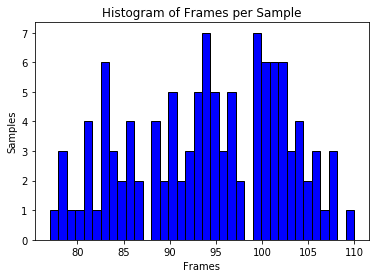

In [7]:
plt.hist([len(sample) for sample in samples], color = 'blue', edgecolor = 'black', bins = int(180/5))

# Add labels
plt.title('Histogram of Frames per Sample')
plt.xlabel('Frames')
plt.ylabel('Samples')

In [8]:
get_sample_name_by_frames_count(110, samples, sample_dir_names)

'backflip-50-joosep'

## Fit and Evaluate Model

In [9]:
y_labels_stacked = np.dstack(y_labels)
print(f"y_labels_stacked shape: {y_labels_stacked.shape}")

y_labels_categorical = to_categorical(y_labels_stacked) 
print(f"y_labels_categorical shape: {y_labels_categorical.shape}")

y_labels_squeezed = np.squeeze(y_labels_categorical)
print(f"y_labels_squeezed shape {y_labels_squeezed.shape}")

(y_rows, y_cols) = y_labels_squeezed.shape
y_labels_list = [[y_labels_squeezed[i, 0], y_labels_squeezed[i, 1]] for i in range(y_rows)]

for idx, y_label in enumerate(y_labels_list):
    if idx == 5:
        break
    print(f"y_label categorical: {y_label}")

y_labels_stacked shape: (1, 1, 113)
y_labels_categorical shape: (1, 1, 113, 2)
y_labels_squeezed shape (113, 2)
y_label categorical: [1.0, 0.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [1.0, 0.0]


In [10]:
def pad_with_zeros(orig_ndarray, desired_rows_count):
    (frames, features) = orig_ndarray.shape

    sample_df = pd.DataFrame(data=orig_ndarray,
                             index=np.arange(frames),
                             columns=np.arange(features))

    zeros_df = pd.DataFrame(0,
                            index=np.arange(desired_rows_count),
                            columns=np.arange(features),
                            dtype='float')

    for i in range(features):
        zeros_df[i] = sample_df[i].astype(float)
    
    
    padded_df = zeros_df.fillna(0)

    return padded_df.to_numpy()

def get_padded_samples(samples):
    padded_samples_list = []

    for idx, sample_ndarray in enumerate(samples):
        desired_rows_count = 110

        padded_ndarray = pad_with_zeros(sample_ndarray, desired_rows_count)

        padded_samples_list = padded_samples_list + [padded_ndarray]
        
    return padded_samples_list

padded_samples_list = get_padded_samples(samples)

def multiply_list(orig_list, times=91):
    result = []
    
    for i in range(1):
        result = result + orig_list
        
    return result
        
padded_samples_beefy_list = multiply_list(padded_samples_list)
y_labels_beefy_list = multiply_list(y_labels_list)

print(f"padded samples len: {len(padded_samples_beefy_list)}, y labels len: {len(y_labels_beefy_list)}")

padded_samples_beefy_ndarray = np.asarray(padded_samples_beefy_list)
y_labels_beefy_ndarray = np.asarray(y_labels_beefy_list)

padded samples len: 113, y labels len: 113


In [11]:
def train_generator(samples, y_labels):
    while True:
        random.shuffle(samples)

        for idx, sample_ndarray in enumerate(samples):
            #desired_rows_count = 110
            
            #padded_ndarray = pad_with_zeros(sample_ndarray, desired_rows_count)
            
            x_train = sample_ndarray
            y_train = y_labels[idx]
        
            (rows_count, features_count) = sample_ndarray.shape
            x_train = x_train.reshape(1, rows_count, features_count)
            y_train = y_train.reshape(1, 6) 
                    
            yield x_train, y_train

In [12]:
def get_blstm_model(lstm_units, n_outputs, n_features, n_timesteps):
    optimizer = Adam(lr=0.0015)
        
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units), input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def get_u_blstm_model(lstm_units, n_outputs, n_features, n_timesteps):
    optimizer = Adam(lr=0.001)
        
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs = 1, 15
    
    #n_steps_per_epoch = 360
    
    lstm_units = 2

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = get_u_blstm_model(lstm_units, n_outputs, n_features, n_timesteps)
    
    
    print(model.summary())
    
    batch_size = 1
    
    es_callback = EarlyStopping(monitor='val_loss', patience=3)
    
    history = model.fit(trainX,
                        trainy,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_split=0.33,
                        callbacks=[es_callback])
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    # fit network
    #model.fit_generator(train_generator(trainX, trainy), steps_per_epoch=n_steps_per_epoch, epochs=epochs, verbose=verbose)
    # evaluate model
    #_, accuracy = model.evaluate_generator(train_generator(testX, testy), steps=len(testX), verbose=0)
    
    return history, accuracy

In [13]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(padded_samples_beefy_ndarray,
                                                    y_labels_beefy_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"X train len: {len(X_train)}, y train len:{len(y_train)} --- X test len:{len(X_test)}, y test len:{len(y_test)}")

train_loss_history = DataFrame()
val_loss_history = DataFrame()

train_accuracy_history = DataFrame()
val_accuracy_history = DataFrame()
# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    last_history = None
    
    for r in range(repeats):
        history, score = evaluate_model(X_train, y_train, X_test, y_test)
        #model, score = evaluate_model(UtrainX, Utrainy, UtestX, Utesty)
        
        # story history
        train_loss_history[str(r)] = history.history['loss']
        val_loss_history[str(r)] = history.history['val_loss']
        train_accuracy_history[str(r)] = history.history['accuracy']
        val_accuracy_history[str(r)] = history.history['val_accuracy']
        
        score = score * 100.0
        print('>#%d validation accuracy: %.3f' % (r+1, score))
        scores.append(score)
        
    # summarize results
    summarize_results(scores)

X train len: 90, y train len:90 --- X test len:23, y test len:23


In [26]:
run_experiment()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 2)                 264       
_________________________________________________________________
dropout_6 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 6         
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________
None
Train on 60 samples, validate on 30 samples
Epoch 1/15
60/60 [==============================] - 4s 65ms/step - loss: 0.6769 - accuracy: 0.6333 - val_loss: 0.6500 - val_accuracy: 0.8667
Epoch 2/15
60/60 [==============================] - 3s 47ms/step

Epoch 9/15
60/60 [==============================] - 2s 35ms/step - loss: 0.6889 - accuracy: 0.5333 - val_loss: 0.6835 - val_accuracy: 0.6667
Epoch 10/15
60/60 [==============================] - 2s 38ms/step - loss: 0.6810 - accuracy: 0.5667 - val_loss: 0.6819 - val_accuracy: 0.6667
Epoch 11/15
60/60 [==============================] - 2s 35ms/step - loss: 0.6796 - accuracy: 0.5667 - val_loss: 0.6816 - val_accuracy: 0.6667
Epoch 12/15
60/60 [==============================] - 2s 38ms/step - loss: 0.6950 - accuracy: 0.5167 - val_loss: 0.6813 - val_accuracy: 0.6667
Epoch 13/15
60/60 [==============================] - 2s 38ms/step - loss: 0.6819 - accuracy: 0.5500 - val_loss: 0.6807 - val_accuracy: 0.6667
Epoch 14/15
60/60 [==============================] - 2s 40ms/step - loss: 0.6817 - accuracy: 0.5500 - val_loss: 0.6814 - val_accuracy: 0.6667
Epoch 15/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6804 - accuracy: 0.5667 - val_loss: 0.7051 - val_accuracy: 0.6000
>#3 val

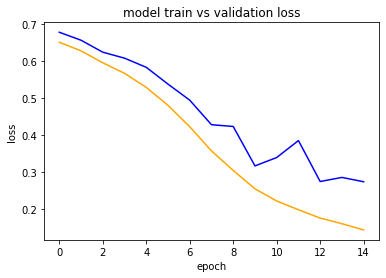

In [28]:
pyplot.plot(train_loss_history['0'], color='blue', label='train')
pyplot.plot(val_loss_history['0'], color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.show()

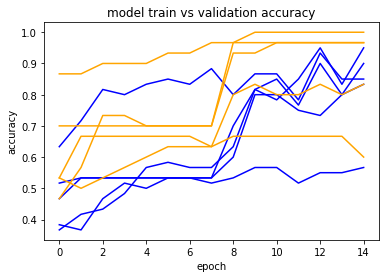

In [29]:
pyplot.plot(train_accuracy_history['0'], color='blue', label='train')
pyplot.plot(val_accuracy_history['0'], color='orange', label='validation')
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.show()